<a href="https://colab.research.google.com/github/MaOdRo/master_dual_encoder/blob/main/ZeroShot_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmark Zero Shot CLIP


**Autor:** Marten Rogall<br>

Code Quellen:<br>
https://github.com/openai/CLIP<br>
https://keras.io/examples/nlp/nl_image_search/


In diesem Notebook wird per Zero Shot Prediction durch CLIP eine Benchmark für die Competition erstellt. Als Evaluationsart wird durch die Top-k Accuracy die Retrieval-Qualität von CLIP getestet. Zunächst werden nur die englischen Trainingsdaten betrachtet und die Performance von CLIP auf diesen monolingualen Datenteil untersucht. Daraufhin wird im Vergeich die Performanze auf den gesamten multilingualen Corpus gezeigt.

-----------------------------------------------------------------
[Vorheriges Colab(Einleitung/Datainspection)](https://colab.research.google.com/drive/1p0GIyOQP1hrQpwrephUh10zfPb5LvikB?hl=de#scrollTo=NvhSaCVS7GGP)

---

[Nächstes Colab(Erstellung des eigenen multilingualen Modells und Trainieren)](https://colab.research.google.com/drive/1hb-9B_D8eXfI7U8YCjC7xenMvu_TvUKh?hl=de#scrollTo=ncMmvClHfnPr)

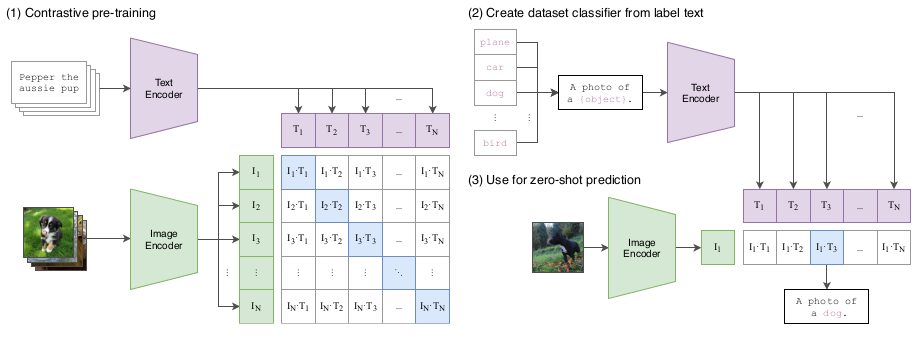

Radford et al. (2021) S. 2. 

CLIP beschreibt ein neuronales Netz, dass durch "Contrastive Language-Image Pre-Training" mit sehr vielen verschiedenen Bild-Caption Paaren trainiert wurde. Das Modell besteht wie in der Abbildung dargestellt aus zwei Encodern. Beim Pretraining werden die Text- und Bildfeatures auf eine vergleichbare Dimension gebracht. Daraufhin wird durch die Vektorembeddings eine Softmax-Matrix erstellt in der durch Cosine Similarity die Ähnlichkeit des Textes und des Bildes ersichtlich wird.

Durch Zero Shot Prediction ist es möglich das CLIP-Modell zu nutzen, um Text- und Bildvergleiche vorzunehmen, ohne das Modell explizit dafür trainiert zu haben. Das Problem, dass im Verlauf des Notebooks gezeigt wird, ist, dass CLIP auf englischen Texten vortrainiert wurde und das es somit bei multilingualen Texten zu Performanceeinbußen kommt.

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-nzhi29jw
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-nzhi29jw
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=7f15311cc4169e75b866c16df2f8bde9e8b1f3fef6250bdec68b11fec18a1b01
  Stored in directory: /tmp/pip-ephem-wheel-cache-swct7z55/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 5.8 MB/s 
  Created wheel for kaggle

### Setup

In [ ]:
############################
#Imports
############################
import os
from pathlib import Path
from google.colab import files
import encodings

import clip
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from PIL import Image
import uuid
from urllib import request
from urllib.request import urlopen
import seaborn as sns
from sklearn.model_selection import train_test_split

Authentifizierung mit dem Kaggle API token(kaggle.json) [Anleitung](https://www.kaggle.com/docs/api)

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [ ]:
!ls trainingdata

fork-of-preprocessedcaptionwikifeatherformat.log  train-00003-of-00005
test						  train-00004-of-00005
test_caption_list				  wikidata-00.log
train-00000-of-00005				  wikidata.csv
train-00001-of-00005				  wiki_test_caption_list.csv
train-00002-of-00005				  wiki_test.csv


In [ ]:
#Erstellen der data und images Directory
Path('./trainingdata').mkdir(exist_ok=True)
Path('./images').mkdir(exist_ok=True)

In [ ]:
!kaggle kernels output martenro/fork-of-preprocessedcaptionwikifeatherformat -p trainingdata

Output file downloaded to trainingdata/test
Output file downloaded to trainingdata/test_caption_list
Output file downloaded to trainingdata/train-00000-of-00005
Output file downloaded to trainingdata/train-00001-of-00005
Output file downloaded to trainingdata/train-00002-of-00005
Output file downloaded to trainingdata/train-00003-of-00005
Output file downloaded to trainingdata/train-00004-of-00005
Output file downloaded to trainingdata/wiki_test.csv
Output file downloaded to trainingdata/wiki_test_caption_list.csv
Output file downloaded to trainingdata/wikidata.csv
Kernel log downloaded to trainingdata/fork-of-preprocessedcaptionwikifeatherformat.log 


In [ ]:
class Config():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 64
    content_length = 77
    content_length_unicode = 60
    n_faktor = 20

In [ ]:
#Globals
DATASET_PATH = './'
D_NAME = 'https://upload.wikimedia.org'
IMAGE_DIR = './images/'

In [ ]:
#df_wiki = pd.read_csv('./trainingdata/wikidata.csv')
#train, test = train_test_split(df_wiki, test_size = 0.2)
#train_data, test_data = train.reset_index(drop = True), test.reset_index(drop = True)

### Hilfsfunktion

In [ ]:
def load_image(link):
    """
    Laden des Bildes aus dem übergebenen Link und Ausgabe als PIL Image
    """
    try:
        URL = link
        filename = str(uuid.uuid4())
        path = f'./images/{filename}'
        req = request.Request(URL)
        req.add_header('User-Agent', 'User-bot-abc')
        response = request.urlopen(req)
        
        with open(path, 'wb') as f:
            f.write(response.read())
        
        image = Image.open(path).convert("RGB")
        
        os.remove(path)
        
        return image
    
    except Exception as e:
        print(e)
        return None

In [ ]:
#Quelle:
#https://stackoverflow.com/questions/13665001/python-truncating-international-string?lq=1

######
#Funktion zum Abschneiden der utf captions auf die CLIP Content Length
######


incr_encoder = encodings.search_function('utf8').incrementalencoder()

def utf8_byte_truncate(text, max_bytes):
    byte_len = 0
    incr_encoder.reset()
    for index,ch in enumerate(text):
        byte_len += len(incr_encoder.encode(ch))
        if byte_len > max_bytes:
            break
    else:
        return text
    return text[:index]

## Downloaden und Speichern des preprocessed Datensatzes

In [ ]:
df_wiki = pd.read_csv('./trainingdata/wikidata.csv')

In [ ]:
df_wiki_lang = pd.DataFrame(df_wiki, columns = ['language', 'image_url','caption_title_and_reference_description'])

df_wiki_relevant = pd.DataFrame(df_wiki, columns = ['image_url','caption_title_and_reference_description'])
df_wiki_relevant


,image_url,caption_title_and_reference_description
0,https://upload.wikimedia.org/wikipedia/commons...,"Giày cao gót </s> Giày cao gót châu Âu, khoảng..."
1,https://upload.wikimedia.org/wikipedia/commons...,Grand Prix automobile de France 1957 </s> Juan...
2,https://upload.wikimedia.org/wikipedia/commons...,道谷站 </s> 車站月台
3,https://upload.wikimedia.org/wikipedia/commons...,北仙台站 </s> 月台
4,https://upload.wikimedia.org/wikipedia/commons...,Silver spoon </s> Two silver-gilt strainer spo...
...,...,...
11771,https://upload.wikimedia.org/wikipedia/commons...,Renault R23 </s> La Renault R23 de Jarno Trull...
11772,https://upload.wikimedia.org/wikipedia/commons...,Chanson des quatre fils Aymon </s> Vue des rui...
11773,https://upload.wikimedia.org/wikipedia/commons...,Дуньхуанская карта </s> Китайский Дуньхуанский...
11774,http://upload.wikimedia.org/wikipedia/commons/...,Géorgiques </s> Le jardin du vieillard corycie...


## Cosine Similarity der 5 häufigste Sprachen 

An Hand der aus dem letzten Notebook bekannten Beispiele der fünf häufigsten Sprachen wird im unteren Bereich das Prinzip des CLIP-Modells genauer erläutert.   

In [ ]:
#Fünf häufigste Sprachen heraussuchen
lang_en_l = df_wiki_lang[df_wiki_lang.language == 'en'].iloc[0]
lang_fr_l = df_wiki_lang[df_wiki_lang.language == 'fr'].iloc[0]
lang_de_l = df_wiki_lang[df_wiki_lang.language == 'de'].iloc[0]
lang_ceb_l = df_wiki_lang[df_wiki_lang.language == 'ceb'].iloc[0]
lang_ja_l = df_wiki_lang[df_wiki_lang.language == 'ja'].iloc[0]

lang_df = [lang_en_l, lang_fr_l, lang_de_l, lang_ceb_l, lang_ja_l]

lang_dict = {}
for lang in lang_df:
    lang_dict[lang['language']] = lang['caption_title_and_reference_description']
    
img_list = []
for img in lang_df:
    img_list.append(img['image_url'])
    
cap_list = []
for cap in lang_df:
    cap_list.append(cap['caption_title_and_reference_description'])

Laden des CLIP-Modells und Darstellung der Modellparameter

In [ ]:
clip_model, preprocess = clip.load("ViT-B/32", device = Config.device)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 72.7MiB/s]


In [ ]:
input_resolution = clip_model.visual.input_resolution
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


Language:  0 en
Caption:  Silver spoon </s> Two silver-gilt strainer spoons and a cignus spoon decorated with a mythical marine creature. (4th century AD Roman spoons from the Hoxne Hoard.)
Language:  1 fr
Caption:  Grand Prix automobile de France 1957 </s> Juan Manuel Fangio et sa Maserati 250F : la combinaison à battre en 1957.
Language:  2 de
Caption:  Ninestar </s> Ninestar G&G Druckerpatronen in einer Berliner Karstadt Filiale.
Language:  3 ceb
Caption:  Johnson Point </s> Mga dapit nga gitawag Johnson Point sa South Georgia and the South Sandwich Islands (Hiniusang Gingharian).
Language:  4 ja
Caption:  国営ひたち海浜公園 </s> 観覧車「プリンセスフラワー」


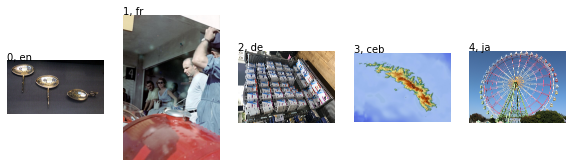

In [ ]:
fig = plt.figure()
fig.set_size_inches(10,5)
for i, (lang, caption) in enumerate(lang_dict.items()):
    image = load_image(img_list[i])
    a=fig.add_subplot(1,len(img_list), i+1)
    plt.text(2, 2, f'{i}, {lang}')
    plt.imshow(image)
    plt.axis('off')
    print("Language: ", i, lang)
    print("Caption: ", caption)

Bevor die Bilder von CLIP verarbeitet werden können, müssen diese noch vereinheitlicht bzw. vorverarbeitet werden. Daraufhin werden sie in Tensor umgewandelt.

In [ ]:
#Image input transformieren
img_input_test = torch.stack([preprocess(load_image(img)).to(Config.device) for img in img_list])

In [ ]:
img_input_test[0]

tensor([[[-1.6901, -1.6901, -1.6901,  ..., -1.7777, -1.7485, -1.7485],
         [-1.7339, -1.7339, -1.7485,  ..., -1.7777, -1.7339, -1.7485],
         [-1.6171, -1.6171, -1.6901,  ..., -1.7777, -1.7339, -1.7339],
         ...,
         [-0.5368, -0.4784, -0.4492,  ..., -0.6390, -0.6536, -0.6390],
         [-0.5806, -0.5806, -0.5514,  ..., -0.5952, -0.6244, -0.6390],
         [-0.5368, -0.5368, -0.5514,  ..., -0.6390, -0.6244, -0.6682]],

        [[-1.6020, -1.6020, -1.5870,  ..., -1.7071, -1.6771, -1.7071],
         [-1.6320, -1.6320, -1.6320,  ..., -1.6921, -1.6621, -1.6921],
         [-1.5420, -1.5270, -1.5570,  ..., -1.6771, -1.6771, -1.6921],
         ...,
         [-0.4614, -0.4464, -0.4464,  ..., -0.5815, -0.5515, -0.5215],
         [-0.5365, -0.5065, -0.4914,  ..., -0.5365, -0.5365, -0.5065],
         [-0.4764, -0.4464, -0.4464,  ..., -0.5815, -0.5365, -0.5515]],

        [[-1.2527, -1.1958, -1.1958,  ..., -1.4518, -1.4233, -1.4233],
         [-1.3238, -1.3096, -1.3665,  ..., -1

### Erstellen der Text & Bildembeddings

Aus den vorverarbeiteten Bildern und den Texten werden nun die Embeddings erstellt. Die Dimension der erstellten Embeddings beträgt für jede Sprache [1, 512] Parameter. Dies ist für die Erstellung eines eigenen Modells im nächsten Notebook wichtig, da der neue, multilinguale Text Encoder ebenfalls auf diese Dimension gebracht werden muss.

In [ ]:
#Textembeddings + Bildembeddings pro Sprache
with torch.no_grad():
    image_embs_test = clip_model.encode_image(img_input_test.to(Config.device)).float()

    language_embs = {}
    for lang, captions in lang_dict.items():
        language_embs[lang] = clip_model.encode_text(clip.tokenize(captions).to(Config.device))

print("CLIP-Vision: {}".format(image_embs_test.shape))
for lang, embs in language_embs.items():
    print("{}: {}".format(lang, embs.shape))

CLIP-Vision: torch.Size([5, 512])
en: torch.Size([1, 512])
fr: torch.Size([1, 512])
de: torch.Size([1, 512])
ceb: torch.Size([1, 512])
ja: torch.Size([1, 512])


Der Text-Input wird tokenized. Die Tokenisierung durch CLIP wird per Satz vorgenommen und mit den Special-Token ' <|startoftext|> X <|endoftext|>' eingebunden. </br> https://huggingface.co/docs/transformers/model_doc/clip

In [ ]:
text_tokens = clip.tokenize([desc for desc in cap_list]).to(Config.device)

In [ ]:
#allgemeine Textembeddings
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens).float().to(Config.device)

In [ ]:
print("CLIP-Text: {}".format(text_features.shape))

CLIP-Text: torch.Size([5, 512])


Als letzter Schritt wird die Cosine-Similarity der Text- und Bildembeddings berechnet und somit deren Ähnlichkeit. (Im Abschnitt "Verlustfunktion" im nächsten Notebook wird die Erstellung der Cosine Similarity genauer beschrieben.)

In [ ]:
image_embs_test /= image_embs_test.norm(dim=-1, keepdim = True)
text_features /= text_features.norm(dim=-1, keepdim = True)
similarity = text_features.cpu().numpy() @ image_embs_test.cpu().numpy().T

In [ ]:
languages = ['en', 'fr', 'de', 'ceb', 'ja']

### Visualisation der Cosine Similarity Matrix

Text(0.5, 1.0, 'Cosine similarity zwischen Text und Bild features')

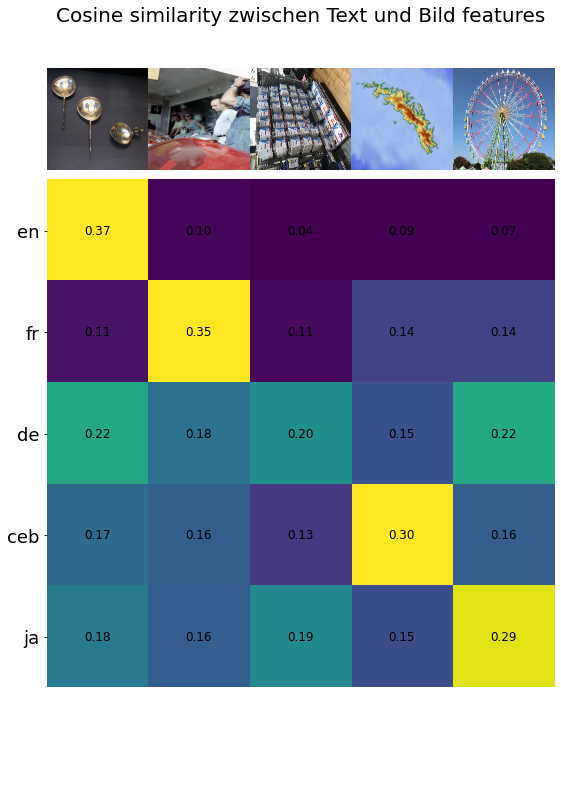

In [ ]:
count = len(img_list)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)

plt.yticks(range(count), languages, fontsize=18)
plt.xticks([])
for i, image in enumerate(img_list):
    plt.imshow(load_image(image), extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between Text und Image features", size=20)

Wie zu sehen, wurde durch CLIP in diesem Beispiel trotz der unterschiedlichen Sprachen eine überwiegend richtige Bestimmung vorgenommen. Außer im Fall des deutschen Bild und Text Paares konnte eine Zuweisung erfolgen. Im nächsten Schritt wird überprüft, ob dies auch auf den gesamten Datensatz übertragbar ist.

---

## Ergebnisse

## Evaluation durch Top-k Accuracy und Retrieval Qualität

Um das CLIP-Modell - und auch später das multilinguale Modell - zu evaluieren, wird die Retrieval-Qualität des Modells mit Hilfe der Top k Accuracy bestimmt. Die Top k Accuracy wurde auf Grund des Ziels der Competition gewählt, die Top 5 ähnlichsten Captions gegeben eines Bildes zu erfassen.
Im Fall der Evaluation wird eine richtige Zuweisung für eine Caption gezählt, falls das zugehörige Bild innerhalb der top k = 20 Treffer zurückgegeben wird.

In [ ]:
#Gesamte image embeddings erstellen
def create_image_embeddings(image_urls):
    hits = 0
    num_batches = int(np.ceil(len(image_urls) / Config.batch_size))
    img_embed = []
    
    for idx in tqdm(range(num_batches)):
        start_idx = idx * Config.batch_size
        end_idx = start_idx + Config.batch_size
        current_image_urls = image_urls[start_idx:end_idx]
        
        img_input = torch.stack([preprocess(load_image(img)).to(Config.device) for img in current_image_urls])
        
        with torch.no_grad():
            current_image_embed = clip_model.encode_image(img_input.to(Config.device)).float()
        
        img_embed.append(current_image_embed)
        del img_input
        del current_image_embed
        torch.cuda.empty_cache()
    img_embeds = torch.cat(img_embed)
    return img_embeds

Die Captions werden wie queries behandelt und mit den Bildembeddings verglichen

In [ ]:
def find_query_match(image_urls, img_emb, queries, n = 5):
    query_tok = clip.tokenize(queries).to(Config.device)
    
    with torch.no_grad():
            cap_emb = clip_model.encode_text(query_tok).float().to(Config.device)
            
    image_embeddings_n = F.normalize(img_emb, p=2, dim=-1)
    text_embeddings_n = F.normalize(cap_emb, p=2, dim=-1)
    
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n)
    
    matches = [[image_urls[idx] for idx in results] for results in indices]

    return matches

### Englische Accuracy


Um einen Vergleich der Performance von CLIP zu haben, wird zunächst nur die Retrieval-Qualität mit dem monolingualen Teildatensatz der englischen Captions überprüft.

In [ ]:
df_wiki_eng = df_wiki[df_wiki.language == 'en']

In [ ]:
df_wiki_eng.describe()

,language,page_url,image_url,page_title,section_title,hierarchical_section_title,caption_reference_description,caption_attribution_description,caption_alt_text_description,mime_type,original_height,original_width,is_main_image,attribution_passes_lang_id,page_changed_recently,context_page_description,context_section_description,caption_title_and_reference_description
count,3335,3335,3335,3335,3335,3335,3335,3335,3335,3335,3335,3335,3335,3335,3335,3335,3335,3335
unique,1,2494,3210,2492,2033,2891,3280,3200,3194,3,1428,1391,3,2,2,2493,2863,3300
top,en,https://en.wikipedia.org/wiki/List_of_New_York...,https://upload.wikimedia.org/wikipedia/commons...,List of New York State Historic Markers in Uls...,Listings County-Wide,List of New York State Historic Markers in Uls...,Historic marker for the house,"Deutsch: Positionskarte von Schottland, Verein...",a picture of the marker,image/jpeg,1836,3264,false,true,False,This is an incomplete list of New York State H...,(147 Markers),List of New York State Historic Markers in Uls...
freq,3335,104,20,104,104,104,10,20,40,2913,93,138,3298,2903,1697,104,104,10


In [ ]:
df_wiki_eng_test = df_wiki_eng.head()

In [ ]:
df_wiki_eng_test

,language,page_url,image_url,page_title,section_title,hierarchical_section_title,caption_reference_description,caption_attribution_description,caption_alt_text_description,mime_type,original_height,original_width,is_main_image,attribution_passes_lang_id,page_changed_recently,context_page_description,context_section_description,caption_title_and_reference_description
4,en,https://en.wikipedia.org/wiki/Silver_spoon,https://upload.wikimedia.org/wikipedia/commons...,Silver spoon,Historical uses,Silver spoon / Historical uses,Two silver-gilt strainer spoons and a cignus s...,English: Two silver strainer spoons and a silv...,"three spoons, two with holes, one with a curve...",image/jpeg,1194,2139,false,true,True,"""The English language expression silver spoon ...",Before the place setting became popular around...,Silver spoon </s> Two silver-gilt strainer spo...
5,en,https://en.wikipedia.org/wiki/List_of_New_York...,https://upload.wikimedia.org/wikipedia/commons...,List of New York State Historic Markers in Uls...,Listings County-Wide,List of New York State Historic Markers in Uls...,Historic marker for the house,English: New York State historical marker for ...,a picture of the marker and the house itself,image/jpeg,1836,3264,false,true,False,This is an incomplete list of New York State H...,(147 Markers),List of New York State Historic Markers in Uls...
6,en,https://en.wikipedia.org/wiki/San_Pedro_Carch%...,https://upload.wikimedia.org/wikipedia/commons...,San Pedro Carchá,Franja Transversal del Norte,San Pedro Carchá / Franja Transversal del Norte,Location of San Pedro Carchá in Franja Transve...,Español: Mapa en relieve de la Franja Transver...,San Pedro Carchá is located in Guatemala,image/jpeg,600,544,false,false,True,"San Pedro Carchá, usually referred to as Carch...","""The Northern Transversal Strip was officially...",San Pedro Carchá </s> Location of San Pedro Ca...
10,en,https://en.wikipedia.org/wiki/Qasigiannguit,https://upload.wikimedia.org/wikipedia/commons...,Qasigiannguit,Population,Qasigiannguit / Population,"Qasigiannguit population growth dynamics, 1991...","Population growth dynamics in Qasigiannguit, G...",Qasigiannguit population dynamics,image/png,250,1000,false,true,True,"Qasigiannguit, formerly Christianshåb, is a to...","With 1,081 inhabitants as of 2020, Qasigianngu...",Qasigiannguit </s> Qasigiannguit population gr...
18,en,https://en.wikipedia.org/wiki/The_Office_Group,https://upload.wikimedia.org/wikipedia/commons...,The Office Group,TOG workspaces and services,The Office Group / TOG workspaces and services,The lounge space at One Canada Square,English: The lounge space at One Canada Square.,Office breakout space with rows of comfortable...,image/jpeg,4912,7360,false,true,False,The Office Group provides over 50 flexible des...,TOG offers a variety of workspaces: including ...,The Office Group </s> The lounge space at One ...


In [ ]:
img_list = df_wiki_eng_test['image_url']
cap_list = df_wiki_eng_test['caption_title_and_reference_description']

In [ ]:
img_input_test = torch.stack([preprocess(load_image(img)).to(Config.device) for img in img_list])

In [ ]:
with torch.no_grad():
    image_embs_test = clip_model.encode_image(img_input_test.to(Config.device)).float()

In [ ]:
text_tokens_test = clip.tokenize([desc for desc in cap_list]).to(Config.device)

In [ ]:
#allgemeine Textembeddings
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens_test).float().to(Config.device)

In [ ]:
image_embs_test /= image_embs_test.norm(dim=-1, keepdim = True)
text_features /= text_features.norm(dim=-1, keepdim = True)
similarity = text_features.cpu().numpy() @ image_embs_test.cpu().numpy().T

In [ ]:
l = ["en", "en", "en", "en", "en"]

Text(0.5, 1.0, 'Cosine similarity between Text und Image features')

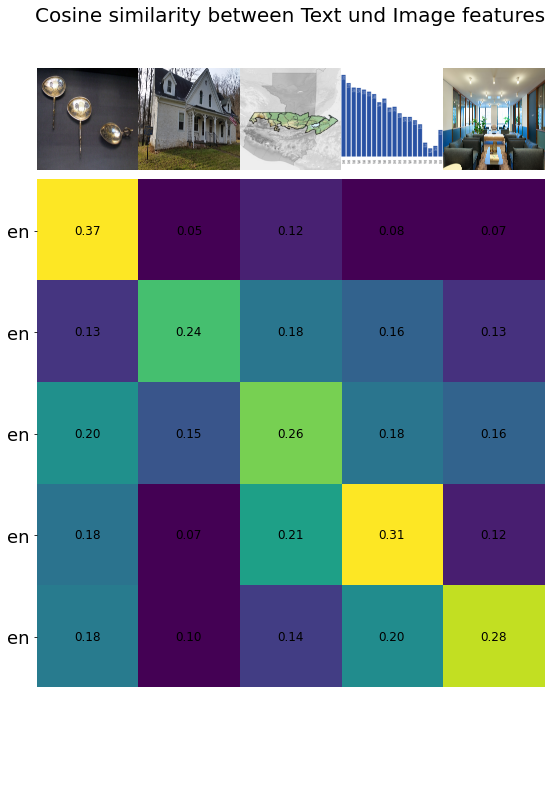

In [ ]:
count = len(img_list)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)

plt.yticks(range(count), l, fontsize=18)
plt.xticks([])
for i, image in enumerate(img_list):
    plt.imshow(load_image(image), extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between Text und Bild features", size=20)

In [ ]:
df_wiki_eng_cap = df_wiki_eng['caption_title_and_reference_description'].tolist()
df_wiki_eng_img = df_wiki_eng['image_url'].tolist()

In [ ]:
#Truncation auf CLIP content length
for i, caption in enumerate(df_wiki_eng_cap):
    if len(caption) > Config.content_length:
        df_wiki_eng_cap[i] = caption[:Config.content_length]

In [ ]:
eval_data_eng = dict(zip(df_wiki_eng_img, df_wiki_eng_cap))

In [ ]:
image_eng_embed = create_image_embeddings(df_wiki_eng_img)

  0%|          | 0/167 [00:00<?, ?it/s]

In [ ]:
def eval_eng_topk_accuracy(image_urls, eval_data, img_embed, n = Config.n_faktor):
    hits = 0
    num_batches = int(np.ceil(len(image_urls) / Config.batch_size))
    
    for idx in tqdm(range(num_batches)):
        start_idx = idx * Config.batch_size
        end_idx = start_idx + Config.batch_size
        current_image_urls = image_urls[start_idx:end_idx]
        
        queries = [
            eval_data[url] for url in current_image_urls 
        ]
        
        result = find_query_match(image_urls, img_embed, queries, n)
        
        #for url in current_image_urls:
            #if url in result:
                #hits = hits + 1

        hits += sum(
            [
                url in matches
                for (url, matches) in list(zip(current_image_urls, result))
            ]
        )
        
    return hits / len(image_urls)
            

print("Scoring english accuracy...")
accuracy = eval_eng_topk_accuracy(df_wiki_eng_img, eval_data_eng, image_eng_embed)
print(f"CLIP accuracy: {round(accuracy * 100, 3)}%")

Scoring english accuracy...


  0%|          | 0/167 [00:00<?, ?it/s]

CLIP accuracy: 78.891%


Die Retrieval-Qualität ist gut und somit die Möglichkeit von CLIP innerhalb des englischen Datensatzes Bilder und Captions zuweisen zukönnen.

### Multilinguale Accuracy

In [ ]:
df_wiki_rel_cap = df_wiki_relevant['caption_title_and_reference_description'].tolist()
df_wiki_rel_img = df_wiki_relevant['image_url'].tolist()

In [ ]:
#Truncation auf CLIP content length
for i, caption in enumerate(df_wiki_rel_cap):
    if len(caption) > Config.content_length:
        df_wiki_rel_cap[i] = caption[:Config.content_length]

In [ ]:
#truncate alle utf-8 strings
for i, caption in enumerate(df_wiki_rel_cap):
    if len(caption.encode('utf-8')) >= Config.content_length_unicode:
        df_wiki_rel_cap[i] = utf8_byte_truncate(caption, Config.content_length_unicode)

In [ ]:
eval_data = dict(zip(df_wiki_rel_img, df_wiki_rel_cap))

In [ ]:
img_embeddings = create_image_embeddings(df_wiki_rel_img)

  0%|          | 0/184 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (105545760 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
def eval_topk_accuracy(image_urls, eval_data, img_embed, n = Config.n_faktor):
    hits = 0
    num_batches = int(np.ceil(len(image_urls) / Config.batch_size))
    
    for idx in tqdm(range(num_batches)):
        start_idx = idx * Config.batch_size
        end_idx = start_idx + Config.batch_size
        current_image_urls = image_urls[start_idx:end_idx]
        
        queries = [
            eval_data[url] for url in current_image_urls
        ]
        
        result = find_query_match(image_urls, img_embed, queries, n)
        
        hits += sum(
            [
                url in matches
                for (url, matches) in list(zip(current_image_urls, result))
            ]
        )

    return hits / len(image_urls)
            
print("Scoring multilingual accuracy...")
accuracy = eval_topk_accuracy(df_wiki_rel_img, eval_data, img_embeddings)
print(f"CLIP accuracy: {round(accuracy * 100, 3)}%")


Scoring multilingual accuracy...


  0%|          | 0/589 [00:00<?, ?it/s]

CLIP accuracy: 35.649%


Bei der Zuweisung der multilingualen Captions zu den Bildern fällt die Performance allerdings auf nur 35.65 %
</br>
Es wird deutlich, dass für die Bearbeitung der Competition nötig ist, ein Modell zu erstellen, dass es schafft multilinguale Embeddings herzustellen und diese den entsprechenden Bilderembeddings zuordnen zu können.

Bei der beispielhaften Suche einer einzelnen Caption: 北仙台站 </ s> 月台 (Kita-Sendai Station </ s> Tsukidai) wird das Vorgehen beim top-k Retrieval noch einmal verdeutlicht.

In [ ]:
def find_one_query_matches(image_urls, img_emb, query, n):
    query_tok = clip.tokenize(query).to(Config.device)
    
    with torch.no_grad():
            cap_emb = clip_model.encode_text(query_tok).float().to(Config.device)
            
            
    image_embeddings_n = F.normalize(img_emb, p=2, dim=-1)
    text_embeddings_n = F.normalize(cap_emb, p=2, dim=-1)
    
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n)
    #matches = []
    matches = [image_urls[idx] for idx in indices]

    return matches

Caption:  北仙台站 </s> 月台


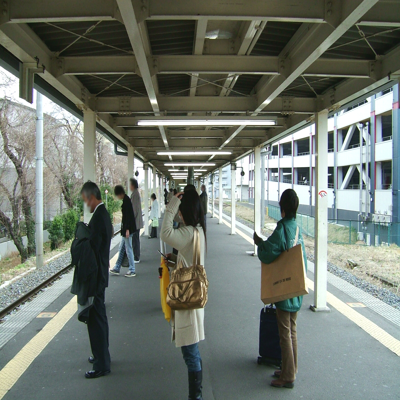

In [ ]:
print("Caption: ", df_wiki_rel_cap[3])
img = load_image(df_wiki_rel_img[3])
img.resize((400, 400))
#Kita-Sendai Station </ s> Tsukidai

In [ ]:
results = find_one_query_matches(df_wiki_rel_img, img_embeddings, df_wiki_rel_cap[3], n = 20)

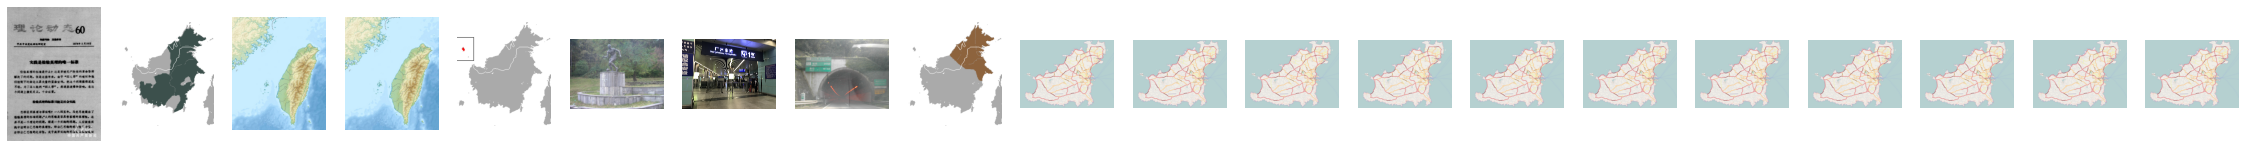

In [ ]:
fig = plt.figure()
fig.set_size_inches(40,5)
for i, img in enumerate(results):
    a=fig.add_subplot(1,len(results), i+1)
    plt.imshow(load_image(img), )
    plt.axis('off')

Da die Performance des Modells bei 35,65% liegt, wird auch beim beispielhaften Suchen nach einem Bild nicht das richtge ausgegeben. Es wurde hier nach dem obigen Bild durch die Caption '北仙台站 月台' gesucht und die Top 20 Ergebnisse sind darunter zu sehen.

## Zwischenfazit

In diesem Notebook wurde gezeigt, wie durch CLIP eine Bild und Text Zuweisung per Zero Shot vorgenommen werden kann. Die Performance von CLIP bei dem englischsprachigen Teildatensatz liegt bei 78,89 % im Vergleich zum multilingualen das bei 35,64 % liegt. Es wird deutlich, dass es nötig ist, für die Bearbeitung der Competition ein multilinguales Modell zu erstellen und dieses dann zu evaluieren.

[Vorheriges Colab(Einleitung/Datainspection)](https://colab.research.google.com/drive/1p0GIyOQP1hrQpwrephUh10zfPb5LvikB?hl=de#scrollTo=NvhSaCVS7GGP)

---

[Nächstes Colab(Erstellung des eigenen multilingualen Modells und Trainieren)](https://colab.research.google.com/drive/1hb-9B_D8eXfI7U8YCjC7xenMvu_TvUKh?hl=de#scrollTo=ncMmvClHfnPr)